In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import torch

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from data import CreatePDEData, PDE_Pseudospectral
from plot_pde_data import plot_1d

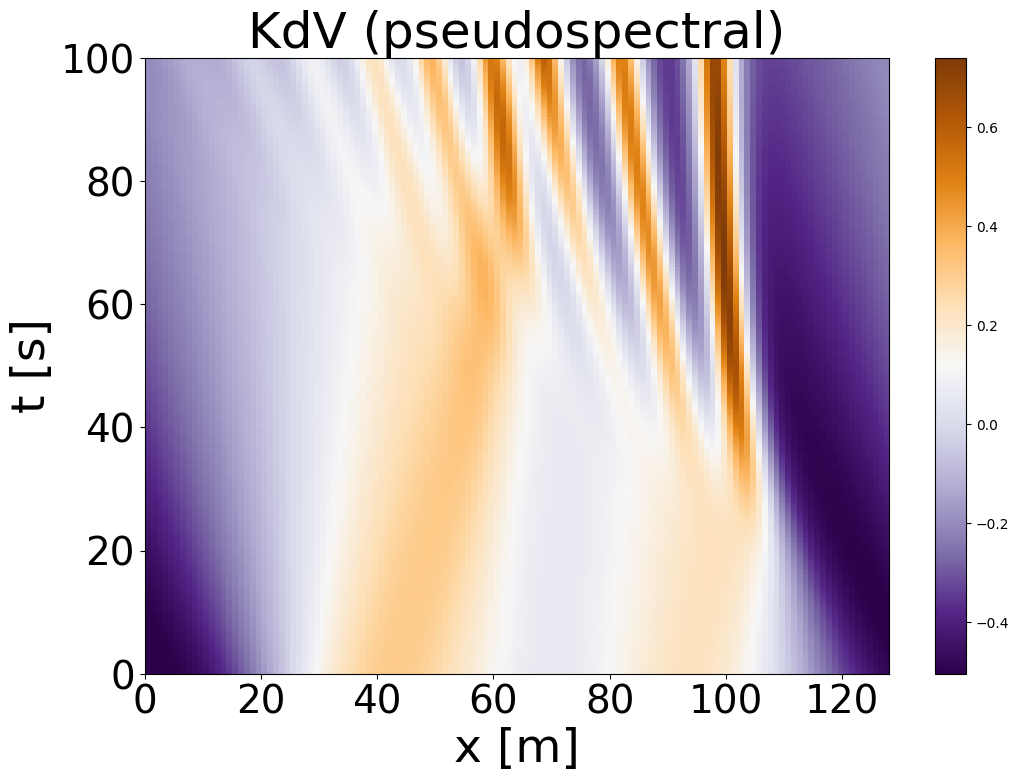

In [2]:
L = 128
T = 100
tol = 1e-6

pde_ps = PDE_Pseudospectral(L=L)

pde_ps.pde1 = lambda t, u: 0.1 * pde_ps.uxx(u)
pde_ps.pde2 = lambda t, u: pde_ps.uxx(u)
pde_ps.pde3 = lambda t, u: -u * pde_ps.ux(u) - pde_ps.uxxx(u)

pde_data = CreatePDEData(L = L, N = 2**7, T = T, Nt = 200)
x = pde_data.x
t = pde_data.t
u0 = pde_data.get_init_cond(x = x, L = L)
func = pde_ps.pde3
sol = pde_data.solve_pde(func, u0 = u0, t = t, tol = tol)

plot_1d(sol, L = L, T = T)

In [3]:
# tols = np.array([1e-3, 1e-4, 1e-5, 1e-6])
# fail_counts = np.array([pde_data.get_data(pde_ps.pde3, tol = tol, N_samples = 100)[1] for tol in tols])

# print(fail_counts) # [49, 43, 36, 46]

# plt.plot(tols, fail_counts, '.-')
# plt.xscale('log')

## LPSDA

In [4]:
from lpda_data_aug import SpaceTranslate, Scale, Galileo, to_coords

In [5]:
generators = [
    SpaceTranslate(max_x_shift=1),
    Galileo(max_velocity=0.1),
    Scale(max_scale=1),
]

In [6]:
X = to_coords(torch.tensor(x), torch.tensor(t))

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
u = (torch.tensor(sol[::-1].copy()), X)
for g in generators:
    u = g(u, shift='fourier')

sol_new, X_new = u[0].numpy(), u[1].numpy()

In [8]:
def get_t_new(sol_new, X_new):
    N = X_new.shape[-2]
    Xmax = (X_new[0, -1, 0] - X_new[0, 0, 0]) * (N+1) / N
    Tmax = X_new[-1, 0, 1] - X_new[0, 0, 1]
    t_new = np.linspace(0, Tmax, sol_new.shape[0])
    return t_new, Xmax

t_new, Xmax = get_t_new(sol_new, X_new)

In [9]:
sol_crosscheck = pde_data.solve_pde(func, u0 = sol_new[0, :], t = t_new, tol = 1e-6)


Root normalized mean squared error: 0.6525456257968963


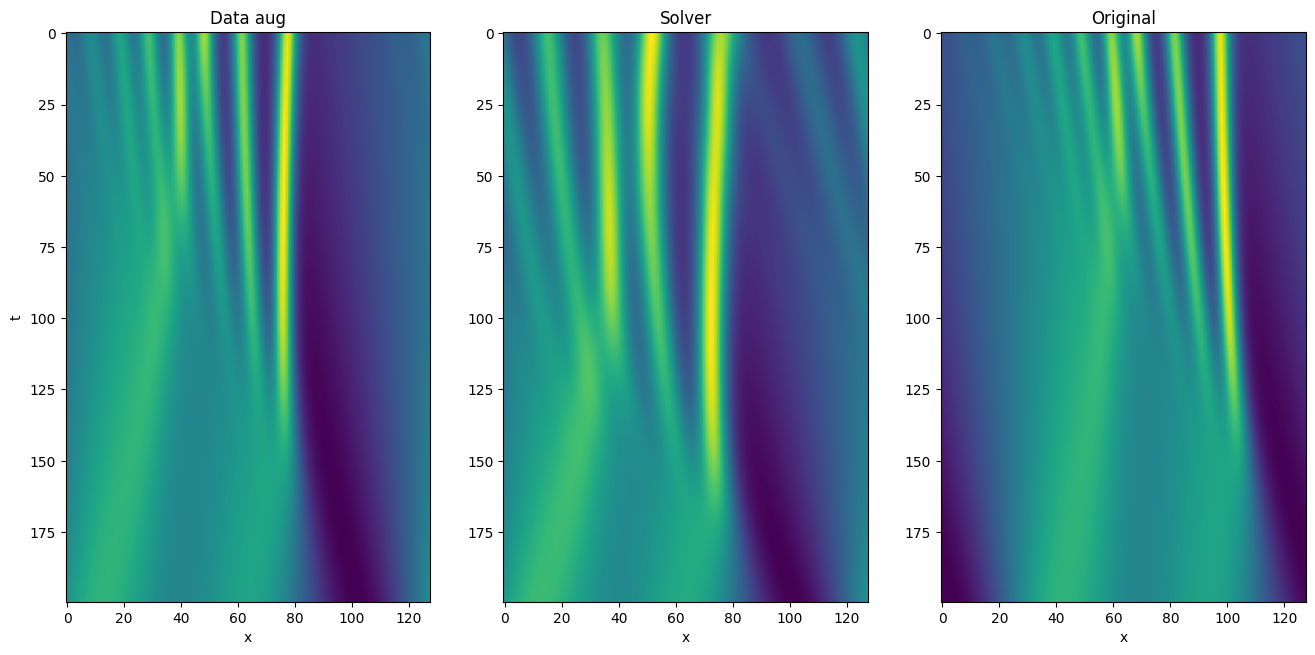

In [10]:
# Calulate the normalized mse between augmented and crosscheck trajectory
mse = np.mean((sol_crosscheck - sol_new[::-1])**2)
normed_mse = mse / np.mean(sol_crosscheck**2)
root_normed_mse = np.sqrt(normed_mse)
print(f'Root normalized mean squared error: {root_normed_mse}')

fig, axes = plt.subplots(1, 3, figsize=(16,8))
axes[0].imshow(sol_new[::-1]) #, extent=[0,Xmax,0,Tmax])
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Data aug')

axes[1].set_title('Solver')
axes[1].imshow(sol_crosscheck) #, extent=[0,Xmax,0,Tmax])
axes[1].set_xlabel('x')

axes[2].set_title('Original')
axes[2].imshow(sol) #, extent=[0,Xmax,0,Tmax])
axes[2].set_xlabel('x')

for ax in axes:
    ax.set_anchor('S')
plt.show()